In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7086782386480918351
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15241374647930292342
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15878710887
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5167970209879366779
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17448181447599514200
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
import torch
print(torch.__version__)


1.5.0


In [3]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Add, UpSampling2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set some parameters
IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1
TRAIN_PATH = '/kaggle/input/lots-of-data-full/training-set-label-full'
TEST_PATH = '/kaggle/input/lots-of-data-full/test-set-label-full'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [4]:
# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [3]:
from skimage.io import imread
from skimage.transform import resize
import numpy as np
import os
from tqdm import tqdm
import sys

# Define your paths
TRAIN_PATH = '/kaggle/input/training-set-label-full/training-set-label-full'
TEST_PATH = '/kaggle/input/training-set-label-full/test-set-label-full'

# Here, train_ids and test_ids should be the names of the folders, e.g., ['image_01', 'image_02', ...]
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

# Define your image dimensions and channels
IMG_HEIGHT = 512  # Example size, set your value
IMG_WIDTH = 512   # Example size, set your value
IMG_CHANNELS = 1  # As needed (3 for RGB, 1 for grayscale, etc.)

# Initialize your image and mask arrays
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    # Image path
    image_path = os.path.join(TRAIN_PATH, id_, 'images')
    # Only get the first image in the folder
    image_file = next(os.walk(image_path))[2][0]
    img = imread(os.path.join(image_path, image_file))[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    
    # Mask path
    mask_path = os.path.join(TRAIN_PATH, id_, 'masks')
    mask_files = next(os.walk(mask_path))[2]
    
    # Initialize a mask placeholder
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in mask_files:
        mask_ = imread(os.path.join(mask_path, mask_file))
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Same process for test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    # Image path
    image_path = os.path.join(TEST_PATH, id_, 'images')
    # Only get the first image in the folder
    image_file = next(os.walk(image_path))[2][0]
    img = imread(os.path.join(image_path, image_file))[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')


Getting and resizing train images and masks ... 


 34%|███▎      | 129/384 [04:13<08:21,  1.97s/it]


KeyboardInterrupt: 

In [26]:
X_train = X_train / 255
Y_train = np.array(Y_train, dtype='float32')

Let's see if things look all right by drawing some random images and their associated masks.

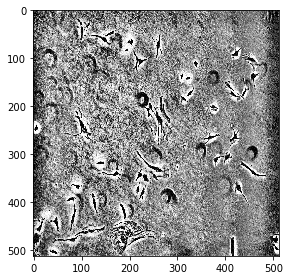

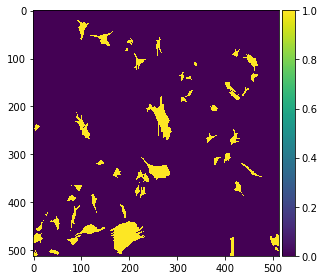

In [14]:

imshow(X_train[5])
plt.show()
imshow(np.squeeze(Y_train[5]))
plt.show()


In [2]:
from PIL import Image
import numpy as np

# Load the image
image_path = '/kaggle/input/ood-dataset/OOB/Dataset 01/exp1_F0001/exp1_F0001-00779.tif'
image = Image.open(image_path)

# Resize the image to 512x512
resized_image = image.resize((512, 512))

# Convert the image to numpy array
image_array = np.array(resized_image, dtype=np.float64)

# Reshape the array to (1, 512, 512, 1)
X_test = image_array.reshape((1, 512, 512, 1))

print(X_test.shape)


(1, 512, 512, 1)


In [11]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
from keras.models import load_model
from tensorflow.keras.optimizers import Adam

# Assuming dice_coef_loss, iou, dice_coef are defined
def dice_coef_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return intersection / (union + K.epsilon())

def dice_coef(y_true, y_pred):
    smooth = 1.
    intersection = K.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)

# Load and preprocess the image
image_path = '/kaggle/input/iitw-dataset/Dataset 02/exp2_F0011/exp1_F0011-01018-1.png'
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 512, 512, 1

# Open image and convert to grayscale if not already
image = Image.open(image_path).convert('L')  # Convert image to grayscale (L mode)
resized_image = image.resize((IMG_WIDTH, IMG_HEIGHT))
image_array = np.array(resized_image, dtype=np.float64)

# Normalize the image if necessary (assuming normalization is needed)
image_array = image_array / 255.0

# Reshape the image to (1, 512, 512, 1)
X_test = image_array.reshape((1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Load your model
model_path = '/kaggle/input/finetuned/model_weights_100.h5'
# Assuming TransResUNet is already defined
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])
model.load_weights(model_path)

# Perform inference
predictions = model.predict(X_test)

# Process the predictions if necessary (e.g., thresholding)
threshold = 0.5
predicted_mask = (predictions > threshold).astype(np.uint8)

print(predicted_mask.shape)

# Extract image name without extension and create directory
image_name = os.path.splitext(os.path.basename(image_path))[0]
output_dir = f'/kaggle/working/{image_name}'
os.makedirs(output_dir, exist_ok=True)

# Visualize and save the output predicted_mask
predicted_mask = predicted_mask.reshape((IMG_HEIGHT, IMG_WIDTH))  # Remove batch and channel dimensions

# Create a larger figure
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(predicted_mask, cmap='gray')
plt.axis('off')

# Save the figure without white borders and text
output_path = f'{output_dir}/predicted_mask.png'
plt.savefig(output_path, dpi=300, bbox_inches='tight', pad_inches=0)
plt.close()  # Close the figure to release memory

# Create a zip file of the output directory
zip_output_path = f'/kaggle/working/{image_name}.zip'
shutil.make_archive(zip_output_path.replace('.zip', ''), 'zip', output_dir)

print(f'Zip file created at: {zip_output_path}')


(1, 512, 512, 1)
Zip file created at: /kaggle/working/exp1_F0011-01018-1.zip


(-0.5, 511.5, 511.5, -0.5)

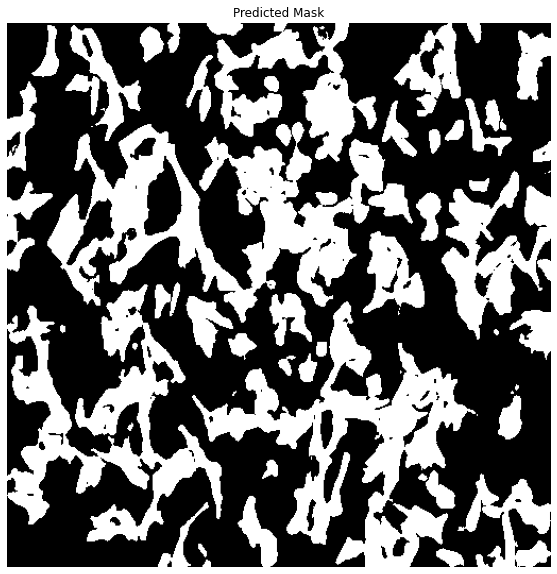

In [38]:
# Create a larger figure
plt.figure(figsize=(10, 10))  # Adjust the figure size as needed
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')
plt.axis('off')



In [10]:
import numpy as np



# Add channel dimensions if missing
if X_test.ndim == 3:
    X_test = np.expand_dims(X_test, axis=-1)
if Y_test.ndim == 3:
    Y_test = np.expand_dims(Y_test, axis=-1)

# Convert X_test to float64 and Y_test to float32
X_test = X_test.astype(np.float64)
Y_test = Y_test.astype(np.float32)

# Confirm the updated data types and shapes
print("X_test dtype:", X_test.dtype)
print("X_test shape:", X_test.shape)
print("Y_test dtype:", Y_test.dtype)
print("Y_test shape:", Y_test.shape)


# Convert X_train to float64 and Y_train to float32
X_train = X_train.astype(np.float64)
Y_train = Y_train.astype(np.float32)

# Confirm the updated data types and shapes for training data
print("X_train dtype:", X_train.dtype)
print("X_train shape:", X_train.shape)
print("Y_train dtype:", Y_train.dtype)
print("Y_train shape:", Y_train.shape)


X_test dtype: float64
X_test shape: (96, 512, 512, 1)
Y_test dtype: float32
Y_test shape: (96, 512, 512, 1)
X_train dtype: float64
X_train shape: (384, 512, 512, 1)
Y_train dtype: float32
Y_train shape: (384, 512, 512, 1)


In [17]:
import numpy as np

# Load the arrays from the saved files
X_train = np.load('/kaggle/input/dataset-npy/dataset-npy/X_train.npy')
X_test = np.load('/kaggle/input/dataset-npy/dataset-npy/X_test.npy')
Y_train = np.load('/kaggle/input/dataset-npy/dataset-npy/Y_train.npy')
Y_test = np.load('/kaggle/input/dataset-npy/dataset-npy/Y_test.npy')

# Print the shapes of the loaded arrays
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)


Shape of X_train: (384, 512, 512, 1)
Shape of X_test: (96, 512, 512, 1)
Shape of Y_train: (384, 512, 512, 1)
Shape of Y_test: (96, 512, 512, 1)


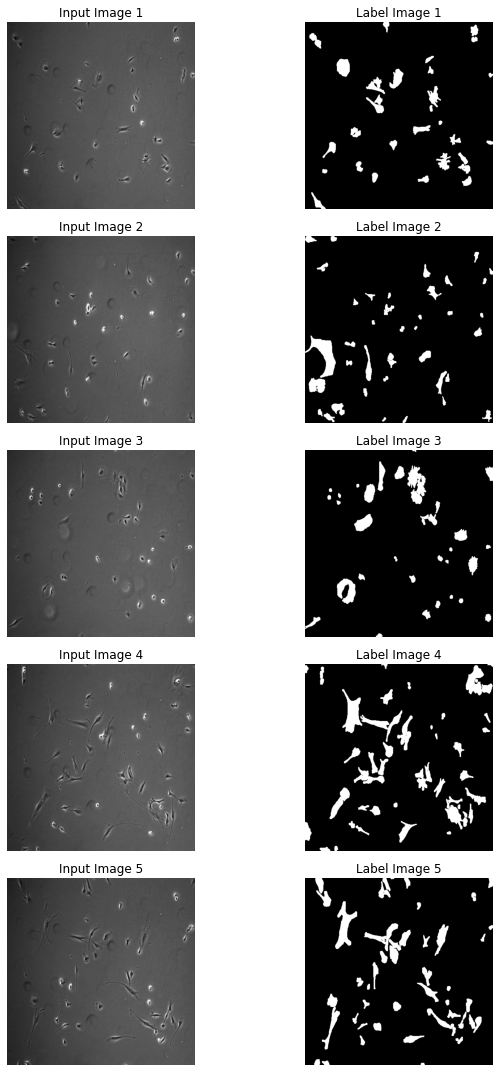

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Load your data (already done in your case)
# X_train = np.load('/kaggle/working/X_train.npy')
# Y_train = np.load('/kaggle/working/Y_train.npy')

def plot_images(X, Y, num_images=5):
    fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 3))
    for i in range(num_images):
        ax = axes[i, 0]
        ax.imshow(X[i].squeeze(), cmap='gray')
        ax.set_title(f'Input Image {i+1}')
        ax.axis('off')

        ax = axes[i, 1]
        ax.imshow(Y[i].squeeze(), cmap='gray')
        ax.set_title(f'Label Image {i+1}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot some images
plot_images(X_train, Y_train, num_images=5)


TypeError: Invalid shape (512, 512, 1) for image data

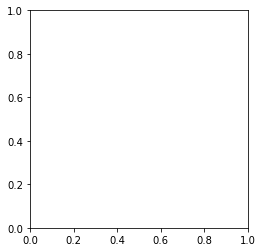

In [8]:
import random
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

# Assuming random and plt have been imported, and X_train, Y_train are already populated

# Choose a random index
ix = random.randint(0, len(train_ids) - 1)

# Display the chosen image
imshow(X_train[ix])
plt.show()

# Display the corresponding mask
imshow(np.squeeze(Y_train[ix]))
plt.show()


In [11]:
print(f"Displaying Image and Mask for index: {ix}, ID: {train_ids[ix]}")
print(f"Image path: {os.path.join(TRAIN_PATH, train_ids[ix], 'images')}")
print(f"Mask path: {os.path.join(TRAIN_PATH, train_ids[ix], 'masks')}")


Displaying Image and Mask for index: 1819, ID: image_968
Image path: /kaggle/input/lots-of-data-full/training-set-label-full/image_968/images
Mask path: /kaggle/input/lots-of-data-full/training-set-label-full/image_968/masks


In [4]:
# From: https://github.com/jocicmarko/ultrasound-nerve-segmentation/blob/master/train.py
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [5]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import *

def res_block(inputs,filter_size):
    """
    res_block -- Residual block for building res path
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for residual block
    filter_size {int} -- convolutional filter size 
    
    Returns:
    add {<class 'tensorflow.python.framework.ops.Tensor'>} -- addition of two convolutional filter output  
    """
    # First Conv2D layer
    cb1 = Conv2D(filter_size,(3,3),padding = 'same',activation="relu")(inputs)
    # Second Conv2D layer parallel to the first one
    cb2 = Conv2D(filter_size,(1,1),padding = 'same',activation="relu")(inputs)
    # Addition of cb1 and cb2
    add = Add()([cb1,cb2])
    
    return add

def res_path(inputs,filter_size,path_number):
    """
    res_path -- residual path / modified skip connection
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for res path
    filter_size {int} -- convolutional filter size 
    path_number {int} -- path identifier 
    
    Returns:
    skip_connection {<class 'tensorflow.python.framework.ops.Tensor'>} -- final res path
    """
    # Minimum one residual block for every res path
    skip_connection = res_block(inputs, filter_size)
    
    # Two serial residual blocks for res path 2
    if path_number == 2:
        skip_connection = res_block(skip_connection,filter_size)
    
    # Three serial residual blocks for res path 1
    elif path_number == 1:
        skip_connection = res_block(skip_connection,filter_size)
        skip_connection = res_block(skip_connection,filter_size)
    
    return skip_connection

def decoder_block(inputs, mid_channels, out_channels):
    
    """
    decoder_block -- decoder block formation
    
    Arguments:
    inputs {<class 'tensorflow.python.framework.ops.Tensor'>} -- input for decoder block
    mid_channels {int} -- no. of mid channels 
    out_channels {int} -- no. of out channels
    
    Returns:
    db {<class 'tensorflow.python.framework.ops.Tensor'>} -- returning the decoder block
    """
    conv_kwargs = dict(
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
        data_format='channels_last'  
    )
    
    # Upsampling (nearest neighbor interpolation) layer
    db = UpSampling2D(size=(2, 2))(inputs)
    # First conv2D layer 
    db = Conv2D(mid_channels, 3, **conv_kwargs)(db)
    # Second conv2D layer
    db = Conv2D(out_channels, 3, **conv_kwargs)(db)

    return db

def TransResUNet(input_size=(512, 512, 1)):
    """
    TransResUNet -- main architecture of TransResUNet
    
    Arguments:
    input_size {tuple} -- size of input image
    
    Returns:
    model {<class 'tensorflow.python.keras.engine.training.Model'>} -- final model
    """
    
    # Input 
    inputs = Input(input_size)
    inp = inputs
    input_shape = input_size
    
    # Handling input channels 
    # input with 1 channel will be converted to 3 channels to be compatible with VGG16 pretrained encoder 
    if input_size[-1] < 3:
        inp = Conv2D(3, 1)(inputs)                         
        input_shape = (input_size[0], input_size[0], 3)  
    else:
        inp = inputs
        input_shape = input_size

    # VGG16 with imagenet weights
    encoder = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
       
    # First encoder block
    enc1 = encoder.get_layer(name='block1_conv1')(inp)
    enc1 = encoder.get_layer(name='block1_conv2')(enc1)
    # Second encoder block
    enc2 = MaxPooling2D(pool_size=(2, 2))(enc1)
    enc2 = encoder.get_layer(name='block2_conv1')(enc2)
    enc2 = encoder.get_layer(name='block2_conv2')(enc2)
    # Third encoder block
    enc3 = MaxPooling2D(pool_size=(2, 2))(enc2)
    enc3 = encoder.get_layer(name='block3_conv1')(enc3)
    enc3 = encoder.get_layer(name='block3_conv2')(enc3)
    enc3 = encoder.get_layer(name='block3_conv3')(enc3)

    # Center block
    center = MaxPooling2D(pool_size=(2, 2))(enc3)
    center = decoder_block(center, 512, 256)

    # Decoder block corresponding to third encoder
    res_path3 = res_path(enc3,128,3)
    dec3 = concatenate([res_path3, center], axis=3)
    dec3 = decoder_block(dec3, 256, 64)
    # Decoder block corresponding to second encoder
    res_path2 = res_path(enc2,64,2)
    dec2 = concatenate([res_path2, dec3], axis=3)
    dec2 = decoder_block(dec2, 128, 64)
    # Final Block concatenation with first encoded feature 
    res_path1 = res_path(enc1,32,1)
    dec1 = concatenate([res_path1, dec2], axis=3)
    dec1 = Conv2D(32, 3, padding='same', kernel_initializer='he_normal')(dec1)
    dec1 = ReLU()(dec1)
   

    # Output
    out = Conv2D(1, 1)(dec1)
    out = Activation('sigmoid')(out)  
    
    # Final model
    model = Model(inputs=[inputs], outputs=[out])
    
    return model

In [15]:
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

NameError: name 'Model' is not defined

In [14]:
# Print the model summary to see detailed information including the number of parameters
model.summary()

NameError: name 'model' is not defined

In [16]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define constants
BATCH_SIZE = 4
EPOCHS = 100

# Ensure the checkpoint directory exists
checkpoint_dir = '/kaggle/working/model_checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Initialize and compile the model
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

# Custom callback for saving metrics to Excel every 5 epochs
class MetricsExcelSaver(Callback):
    def __init__(self):
        super().__init__()
        self.history_data = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history_data.append(logs)
        if (epoch + 1) % 5 == 0:
            df = pd.DataFrame(self.history_data)
            excel_path = f'/kaggle/working/epoch_{epoch + 1}_metrics.xlsx'
            df.to_excel(excel_path, index=False)
            print(f'Metrics saved to {excel_path}')

# Callback for saving model weights every 5 epochs
checkpoint_path = "/kaggle/working/model_checkpoint/model_weights_{epoch:03d}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    period=5,  # Save every 5 epochs
    verbose=1
)

# Train the model
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    callbacks=[MetricsExcelSaver(), model_checkpoint_callback],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE
)

# Evaluate the model
results = model.evaluate(x_test, y_test)
results = dict(zip(model.metrics_names, results))

# Print final evaluation results
print("Final model evaluation:")
print(results)


NameError: name 'X_train' is not defined

In [18]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split

# Define constants
BATCH_SIZE = 4
EPOCHS = 100
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 512, 512, 1  # Example dimensions

# Ensure the checkpoint directory exists
checkpoint_dir = '/kaggle/working/model_checkpoint'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Initialize and compile the model
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

# Load weights if the specified file exists
initial_weights_path = '/kaggle/input/model-weights-50-extended/model_weights_050_extended.h5'
if os.path.exists(initial_weights_path):
    try:
        model.load_weights(initial_weights_path, by_name=True)
        print(f"Loaded weights from {initial_weights_path} using layer names.")
    except Exception as e:
        print(f"Failed to load weights from {initial_weights_path}. Error: {e}")

# Custom callback for saving metrics to Excel every 5 epochs
class MetricsExcelSaver(Callback):
    def __init__(self):
        super().__init__()
        self.history_data = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.history_data.append(logs)
        if (epoch + 1) % 5 == 0:
            df = pd.DataFrame(self.history_data)
            excel_path = f'/kaggle/working/epoch_{epoch + 1}_metrics.xlsx'
            df.to_excel(excel_path, index=False)
            print(f"Metrics saved to {excel_path}")

# Callback for saving model weights every 5 epochs, less verbose
checkpoint_path = "/kaggle/working/model_checkpoint/model_weights_{epoch:03d}.h5"
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    save_freq=5 * len(x_train) // BATCH_SIZE,  # Ensure this calculation is correct
    verbose=0  # Turn off verbosity to reduce the frequency of the output
)


# Train the model
history = model.fit(
    x_train, y_train,
    epochs=EPOCHS,
    callbacks=[MetricsExcelSaver(), model_checkpoint_callback],
    validation_data=(x_test, y_test),
    batch_size=BATCH_SIZE
)

# Evaluate the model
results = model.evaluate(x_test, y_test)
results = dict(zip(model.metrics_names, results))

# Print final evaluation results
print("Final model evaluation:")
for metric, value in results.items():
    print(f"{metric}: {value}")


NameError: name 'K' is not defined

In [13]:
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from time import time

# Assuming dice_coef_loss, iou, dice_coef are already defined elsewhere in your code
# If not, you will need to define or import these as well before running this script

# Path to your pre-trained model weights
model_path = '/kaggle/input/finetuned/model_weights_100.h5'

# Define image dimensions and channels (assuming they are already known)
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 512, 512, 1

# Load your model
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(learning_rate=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])
model.load_weights(model_path)

# Load the test data (adjust the path as needed)
X_test = np.load('/kaggle/input/dataset-npy/dataset-npy/X_test.npy')

# Prepare a single image for inference
# Assuming your model expects a single image with batch dimension
input_image = X_test[0:1]  # Select the first image and add batch dimension

# Start timing the inference
start_time = time()
# Perform inference
predictions = model.predict(input_image)
# End timing the inference
end_time = time()

# Print the inference time
print(f"Inference time for one image: {end_time - start_time} seconds")


Inference time for one image: 3.700575351715088 seconds


In [20]:
print("Model Summary:")
print(model.summary())


Model Summary:
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        input_9[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 256, 256, 64) 36928       block1_conv1[1][0]               
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 64) 0           block1_conv2[1][0]               
_____________________________________________________________________________

In [7]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 2, shuffle=False)

BATCH_SIZE = 4 
EPOCHS = 100

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Define constants
BATCH_SIZE = 4
EPOCHS = 100

# Initialize lists for storing results
histories = []
losses = []
accuracies = []
dicecoefs = []
ious = []

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Initialize and compile the model
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[iou, dice_coef, 'binary_accuracy'])

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint('unet_nuclei_seg.hdf5', verbose=1, save_best_only=True)

# Train the model
history = model.fit(x_train, y_train,
                    epochs=EPOCHS,
                    callbacks=[model_checkpoint],
                    validation_data=(x_test, y_test),
                    batch_size=BATCH_SIZE)

# Load the best model saved by ModelCheckpoint
model = load_model('unet_nuclei_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

# Evaluate the model
results = model.evaluate(x_test, y_test)
results = dict(zip(model.metrics_names, results))

# Store results
histories.append(history)
accuracies.append(results['binary_accuracy'])
losses.append(results['loss'])
dicecoefs.append(results['dice_coef'])
ious.append(results['iou'])

# Print final evaluation results
print("Final model evaluation:")
print(results)


In [4]:
import os
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K

# Define Dice Coefficient for metric
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

# Define Dice Loss for training
def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Define Intersection over Union (IoU) as a metric
def iou(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred))
    sum_ = K.sum(K.square(y_true)) + K.sum(K.square(y_pred))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# Custom Callback for saving the model every 5 epochs
class SaveEveryNEpochs(Callback):
    def __init__(self, save_path, period=5):
        super(SaveEveryNEpochs, self).__init__()
        self.save_path = save_path
        self.period = period

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.period == 0:
            filename = 'model_epoch_{}.hdf5'.format(epoch + 1)
            self.model.save(os.path.join(self.save_path, filename))
            print('Model saved at epoch {}'.format(epoch + 1))

# Define the model architecture
def TransResUNet(input_size):
    inputs = Input(input_size)
    # Example layers (simplified for brevity)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    u2 = UpSampling2D((2, 2))(c2)
    merge = concatenate([c1, u2], axis=3)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same')(merge)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c3)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Initialize the model
model = TransResUNet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# Assuming X_train, Y_train, X_test, Y_test are already loaded and preprocessed
x_train, y_train = X_train, Y_train
x_test, y_test = X_test, Y_test

# Compile the model with new optimizer settings if needed
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef, iou, 'binary_accuracy'])

# Define the path where the model checkpoint will be saved
checkpoint_dir = '/kaggle/working/'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Initialize callbacks
every_five_epochs_saver = SaveEveryNEpochs(checkpoint_dir, period=5)

# Start training
print("Starting training...")
history = model.fit(
    x_train, y_train,
    epochs=100,  # Set more or less epochs depending on your needs
    callbacks=[every_five_epochs_saver],
    validation_data=(x_test, y_test),
    batch_size=2  # Modify batch size if needed
)

# Evaluate the model
results = model.evaluate(x_test, y_test)
print(f"Evaluation results: {results}")

print("Training and evaluation complete.")


Starting training...
Train on 2459 samples, validate on 96 samples
Epoch 1/100
2459/2459 [==============================] - 40s 16ms/sample - loss: -0.0892 - dice_coef: 0.0892 - iou: 0.0795 - binary_accuracy: 0.0477 - val_loss: -0.1383 - val_dice_coef: 0.1383 - val_iou: 0.0749 - val_binary_accuracy: 0.0747
Epoch 2/100
2459/2459 [==============================] - 36s 15ms/sample - loss: -0.1086 - dice_coef: 0.1086 - iou: 0.1063 - binary_accuracy: 0.4874 - val_loss: -0.1383 - val_dice_coef: 0.1383 - val_iou: 0.0749 - val_binary_accuracy: 0.0747
Epoch 3/100
2459/2459 [==============================] - 36s 15ms/sample - loss: -0.2115 - dice_coef: 0.2115 - iou: 0.2975 - binary_accuracy: 0.9546 - val_loss: -0.1383 - val_dice_coef: 0.1383 - val_iou: 0.0749 - val_binary_accuracy: 0.0747
Epoch 4/100
2459/2459 [==============================] - 36s 15ms/sample - loss: -0.3655 - dice_coef: 0.3655 - iou: 0.3752 - binary_accuracy: 0.9605 - val_loss: -0.1383 - val_dice_coef: 0.1383 - val_iou: 0.0749

KeyboardInterrupt: 

In [18]:
print('accuracies : ', accuracies)
print('losses : ', losses)
print('dicecoefs : ', dicecoefs)
print('ious : ', ious)

print('-----------------------------------------------------------------------------')
print('-----------------------------------------------------------------------------')

print('average accuracy : ', np.mean(np.array(accuracies)))
print('average loss : ', np.mean(np.array(losses)))
print('average dicecoefs : ', np.mean(np.array(dicecoefs)))
print('average ious : ', np.mean(np.array(ious)))
print()

print('standard deviation of accuracy : ', np.std(np.array(accuracies)))
print('standard deviation of loss : ', np.std(np.array(losses)))
print('standard deviation of dicecoefs : ', np.std(np.array(dicecoefs)))
print('standard deviation of ious : ', np.std(np.array(ious)))

accuracies :  [0.9631567, 0.9655647]
losses :  [-0.8529345095157623, -0.8589254518349966]
dicecoefs :  [0.85293454, 0.8589255]
ious :  [0.77210766, 0.78138334]
-----------------------------------------------------------------------------
-----------------------------------------------------------------------------
average accuracy :  0.9643607
average loss :  -0.8559299806753795
average dicecoefs :  0.85593003
average ious :  0.7767455

standard deviation of accuracy :  0.0012040138
standard deviation of loss :  0.0029954711596171246
standard deviation of dicecoefs :  0.002995491
standard deviation of ious :  0.0046378374


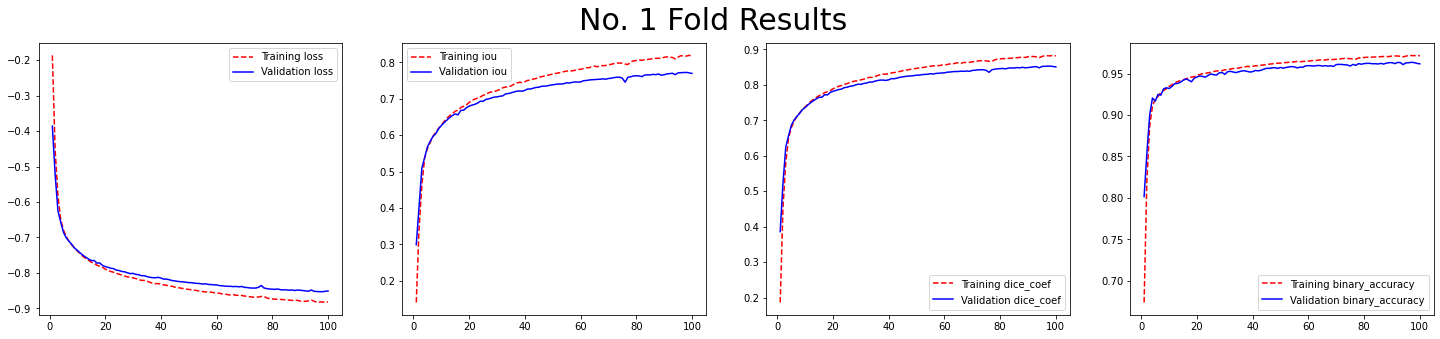

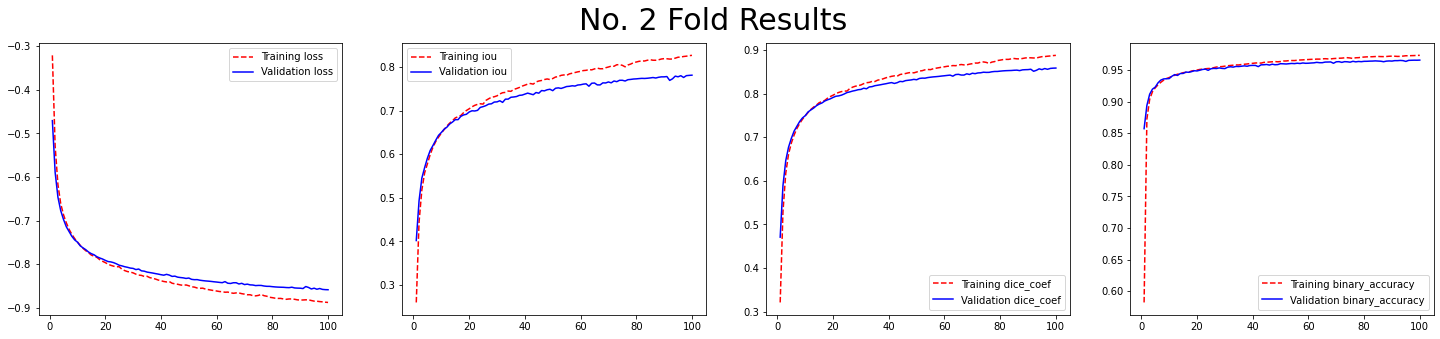

In [19]:
import pickle

for h, history in enumerate(histories):

    keys = history.history.keys()
    fig, axs = plt.subplots(1, len(keys)//2, figsize = (25, 5))
    fig.suptitle('No. ' + str(h+1) + ' Fold Results', fontsize=30)

    for k, key in enumerate(list(keys)[:len(keys)//2]):
        training = history.history[key]
        validation = history.history['val_' + key]

        epoch_count = range(1, len(training) + 1)

        axs[k].plot(epoch_count, training, 'r--')
        axs[k].plot(epoch_count, validation, 'b-')
        axs[k].legend(['Training ' + key, 'Validation ' + key])
        
    with open(str(h+1) + '_mri_trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

In [20]:
selector = np.argmin(abs(np.array(ious) - np.mean(ious)))
model = load_model(str(selector+1) +'_unet_nuclei_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

In [21]:
for i in range(20):
    index=np.random.randint(1,len(X_train))
    pred=model.predict(X_train_process[index][np.newaxis, :, :, :])

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(X_train[index])
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(Y_train[index]))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Predicted mask')
    plt.show()

NameError: name 'X_train_process' is not defined